**Reddit Sentiment Analysis on Women's Fast fashion brands**

Extracting data on Women's fashion brands from reddit

In [ ]:
import re
import praw       #reddit API wrapper
import pandas as pd
from praw.models import Comment       #coment model check

reddit = praw.Reddit(client_id='elyMWN77HxOTrTifowynEg', 
                     client_secret='YT8iuymVoWNmJKiwkp343xo6g2KDng', 
                     user_agent='fashion analytics by u/Cluty_Row9012')   # initialize reddit client with credentials




Defining brand names to search and subreddits to scan

In [15]:

brands   = ["Zara", "H&M", "Uniqlo", "Gap", "Mango", "Madewell"]
subs     = ["femalefashionadvice"]  
query = " OR ".join(brands)
rows = []
for sub in subs:
    for post in reddit.subreddit(sub).search(query, sort='relevance',time_filter='all', limit=1500):   
        texts = [post.title, post.selftext] + [c.body for c in post.comments.list() if isinstance(c, praw.models.Comment)]   # collect title,desciptin and conments text of a post.
        for brand in brands:
            pattern = re.compile(rf"\b{re.escape(brand)}\b", flags=re.I)
            for t in texts:
                if pattern.search(t):
                    rows.append({"brand": brand, "text": t[:9500]}) 

In [17]:
df = pd.DataFrame(rows).drop_duplicates()
print(f"Collected {len(df):,} snippets.")
df.to_csv("reddit_data.csv", index=False, encoding="utf-8")  
print("Saved data to reddit_data.csv")

Collected 4,867 snippets.
Saved data to reddit_data.csv


Method 1: Sentiment Analysis using TextBlob

In [18]:
from textblob import TextBlob
from collections import Counter
# Apply TextBlob to each text snippet and get polarity, subjectivity
df['polarity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

print(df[['text', 'polarity', 'subjectivity']].head())

                                                text  polarity  subjectivity
0  I'm sure people will bring up labour ethics bu...  0.265625      0.645486
1  In my opinion, the fabric content matters, not...  0.078889      0.381296
2  In addition to what other people have mentione...  0.082143      0.484127
3  1 - stores like Aritzia and Zara tend to be tr...  0.200000      0.550000
4  I don't get it either~ haha I'm usually here f... -0.016667      0.225000


Categorizing sentiments

In [19]:
def sentiment_category(row):                                  
    if row['subjectivity'] > 0.5 and abs(row['polarity']) < 0.1:
        return 'mixed'
    elif row['polarity'] > 0.1:
        return 'positive'
    elif row['polarity'] < -0.1:
        return 'negative'
    else:
        return 'neutral'

df['sentiment'] = df.apply(sentiment_category, axis=1)   
df.to_csv("textblob_sentiment.csv", index=False, encoding="utf-8")  
print("Saved data to reddit_data.csv")

values = Counter(df['sentiment'])

for value, count in values.items():
    print(f"{value} : {count}")



Saved data to reddit_data.csv
positive : 2803
neutral : 1215
mixed : 542
negative : 307


Method 2: Sentiment Analysis using Google Natural Language API

In [ ]:
pip install google-cloud-language      

In [9]:
from google.cloud import language_v1
import matplotlib.pyplot as plt
import google.auth

In [ ]:
client = language_v1.LanguageServiceClient(credentials=credentials)        # Setup Google API client

def analyze_sentiment(text):                                    
    if not isinstance(text, str):
        text = str(text)
    document = language_v1.Document(content=text, type_=language_v1.Document.Type.PLAIN_TEXT)
    try:                                                    # To check the API
        print(f"Analyzing sentiment for text: {text[:50]}...")  
        sentiment = client.analyze_sentiment(request={'document': document}).document_sentiment
        print(f"Sentiment analysis successful for text: {text[:50]}...")
        return sentiment.score, sentiment.magnitude
    except Exception as e:
        print(f"Error analyzing sentiment for text: {text[:50]}...")
        print("Full Exception:", type(e), str(e))  
        return None, None

dfs = pd.read_csv("reddit_data.csv")                  #load reddit data to perform analysis

dfs[['polarity', 'subjectivity']] = dfs['text'].apply(lambda x: pd.Series(analyze_sentiment(x)))

def label_sentiment(row):                                  #categorizing sentiments.
    score = row['polarity']
    mag = row['subjectivity']
    if score is None:
        return "unknown"
    if abs(score) < 0.1 and mag > 0.5:
        return "mixed"
    elif score > 0.1:
        return "positive"
    elif score < -0.1:
        return "negative"
    else:
        return "neutral"

dfs['sentiment'] = dfs.apply(label_sentiment, axis=1)

dfs.to_csv("sentiment_results.csv", index=False)
print("Saved results to sentiment_results.csv")

Analyzing sentiment for text: I'm sure people will bring up labour ethics but to...
Sentiment analysis successful for text: I'm sure people will bring up labour ethics but to...
Analyzing sentiment for text: In my opinion, the fabric content matters, not the...
Sentiment analysis successful for text: In my opinion, the fabric content matters, not the...
Analyzing sentiment for text: In addition to what other people have mentioned, I...
Sentiment analysis successful for text: In addition to what other people have mentioned, I...
Analyzing sentiment for text: 1 - stores like Aritzia and Zara tend to be trendi...
Sentiment analysis successful for text: 1 - stores like Aritzia and Zara tend to be trendi...
Analyzing sentiment for text: I don't get it either~ haha I'm usually here for t...
Sentiment analysis successful for text: I don't get it either~ haha I'm usually here for t...
Analyzing sentiment for text: We can talk all day about it being about "ethics" ...
Sentiment analysis success

In [ ]:
values = Counter(dfs['sentiment'])

for value, count in values.items():
    print(f"{value} : {count}")

negative : 1524
mixed : 719
positive : 2392
neutral : 232



Pivot Table:
 sentiment  mixed  negative  neutral  positive
brand                                        
Gap          145       277       37       446
H&M          212       440       30       475
Madewell      92       141       36       357
Mango         15        51       13        99
Uniqlo       141       275       81       689
Zara         114       340       35       326


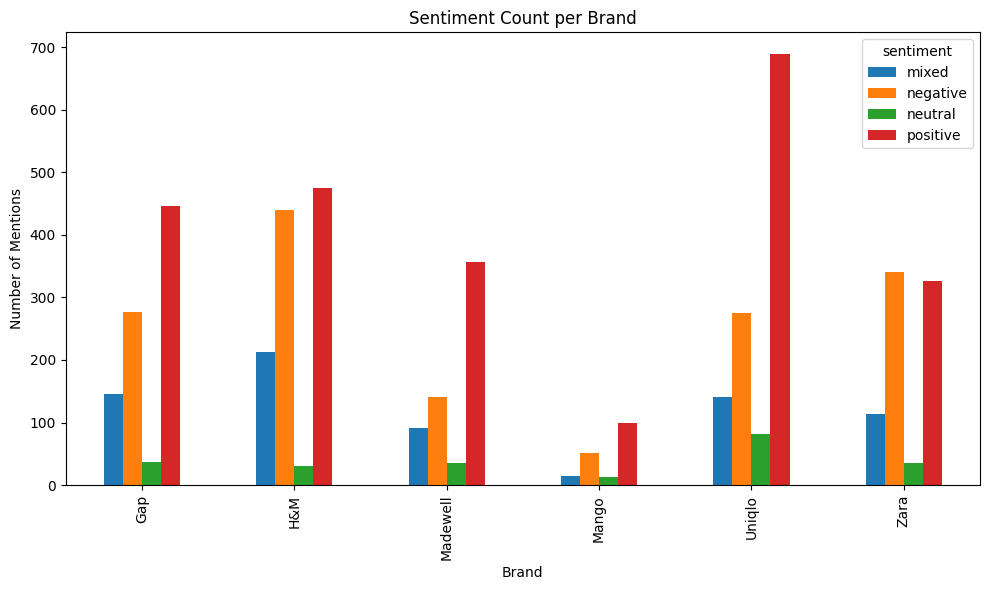

In [ ]:
# Pivot table for analysis
pivot = dfs.pivot_table(index='brand', columns='sentiment', values='text', aggfunc='count', fill_value=0)
print("\nPivot Table:\n", pivot)

# Plot the pivot table as a bar chart
pivot.plot(kind='bar', figsize=(10,6))
plt.title('Sentiment Count per Brand')
plt.ylabel('Number of Mentions')
plt.xlabel('Brand')
plt.tight_layout()
plt.show()